In [1]:
import numpy as np
import scipy.io as sio
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import matplotlib.animation as animation
% matplotlib notebook

from discretize_gamma_theta_peaks import discretize_gamma_theta_peaks

'''
RL96 data
1x574 cell
9801x6 double

Sampling rate is 2000 Hz, and each cell has 9801 sampled points by 6 recording channels:

1 - Thermocouple
2 - Olfactory bulb
3 - Piriform cortex
4 - Dentate gyrus
5 - CA1
6 - V1M
'''

channel_names = ['Thermocouple','Olfactory bulb','Piriform cortex','Dentate gyrus','CA1','V1M']
data_master = sio.loadmat('/Users/brainbow/Documents/LFP_Sonification/raw_lfp_mat_files/RL96_HomeCage.mat')['MasterData_RL96_Base']
print('data_master.shape',data_master.shape)
print('data_master[0,0].shape',data_master[0,0].shape)

Fs = 2000 # Hz
tvec = np.arange(0,data_master[0,0].shape[0]/Fs,1/Fs)


data_master.shape (1, 574)
data_master[0,0].shape (9801, 6)


<IPython.core.display.Javascript object>


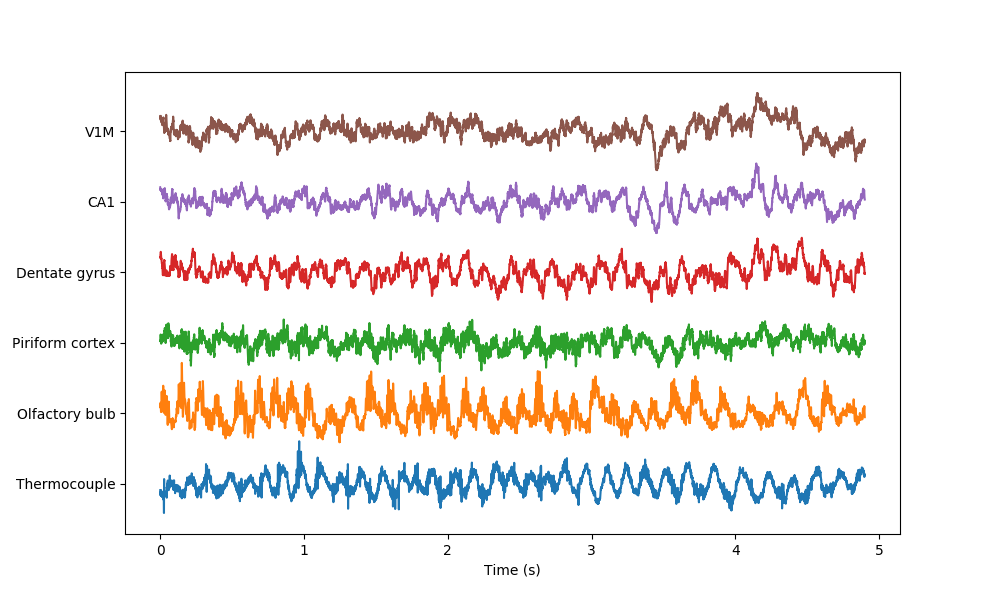

([<matplotlib.axis.YTick at 0x12a44aa90>,
 <a list of 6 Text yticklabel objects>)

In [9]:
sess = 1 # choose which session to plot

# description of some selected sessions
#155 huge gamma
#1,355 fast gamma/theta
#33,505 medium gamma/theta
#118,500 beta
#219 slow gamma/theta/beta

offset = 10
plt.figure(figsize=(10,6))
for i,ch in enumerate(range(len(channel_names))):
    plt.plot(tvec,i*offset+data_master[0,sess][:,ch])
plt.xlabel('Time (s)')
plt.yticks(offset*np.arange(len(channel_names)),channel_names)

<IPython.core.display.Javascript object>


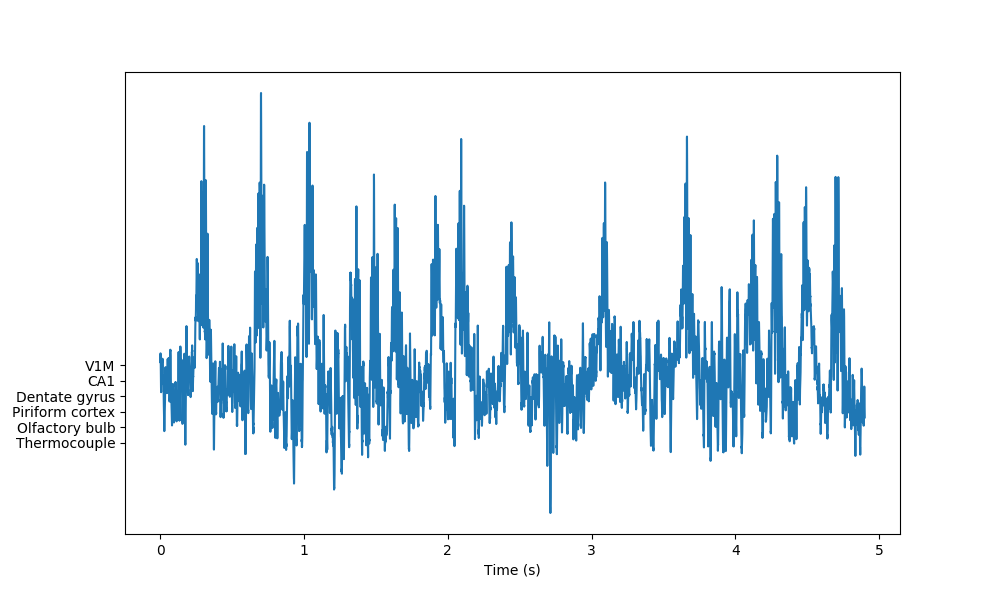

([<matplotlib.axis.YTick at 0x12a14c048>,
 <a list of 6 Text yticklabel objects>)

In [8]:
sess = 155 # choose which session to plot

# description of some selected sessions
#155 huge gamma
#1,355 fast gamma/theta
#33,505 medium gamma/theta
#118,500 beta
#219 slow gamma/theta/beta

plt.figure(figsize=(10,6))
plt.plot(tvec,i*offset+data_master[0,sess][:,1])
plt.xlabel('Time (s)')

In [3]:
sess = 155
signal = data_master[0,sess][:,1]

out_dict = discretize_gamma_theta_peaks(signal, Fs=2000, Fds=100, Fbn=20)
out_dict.keys()

dict_keys(['tvec_ds', 'gamma_env_ds', 'gamma_env_peak_times', 'gamma_env_peak_hights', 'theta_filt_ds', 'theta_filt_peak_times', 'theta_filt_peak_hights', 'masked_gamma_env', 'masked_theta_filt', 'binned_gamma_sonify', 'binned_theta_sonify', 'binned_theta'])

In [5]:
# save binned theta peaks
np.savetxt(f'data_files/RL96_OB_sess{sess}_theta_filt_5s_binned_20Hz.txt', out_dict['binned_theta_sonify'], fmt='%d', newline=',')
# save binned gamma peaks
np.savetxt(f'data_files/RL96_OB_sess{sess}_gamma_env_5s_binned_20Hz.txt', out_dict['binned_gamma_sonify'], fmt='%d', newline=',')

<IPython.core.display.Javascript object>


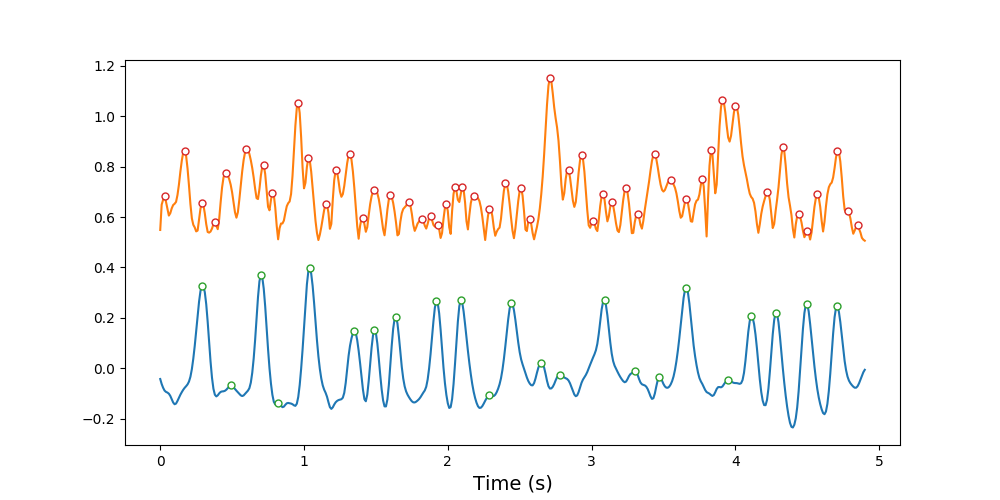

Text(0.5,0,'Time (s)')

In [4]:
offset = 0.5
gs = 3 # gamma scale
plt.figure(figsize=(10,5))
plt.plot(out_dict['tvec_ds'],out_dict['theta_filt_ds'])
plt.plot(out_dict['tvec_ds'],offset+3*out_dict['gamma_env_ds'])
plt.plot(out_dict['tvec_ds'],out_dict['masked_theta_filt'], "o",markersize=5, markerfacecolor='w') # plot masked time series rather than amplitude at peaks
#plt.plot(out_dict['theta_filt_peak_times'],out_dict['theta_filt_peak_hights'], "x")
plt.plot(out_dict['tvec_ds'],offset+3*out_dict['masked_gamma_env'], "o",markersize=5, markerfacecolor='w')
#plt.plot(out_dict['gamma_env_peak_times'], offset+3*out_dict['gamma_env_peak_hights'], "x")
plt.xlabel('Time (s)',fontsize=14)
#plt.yticks([])

<IPython.core.display.Javascript object>


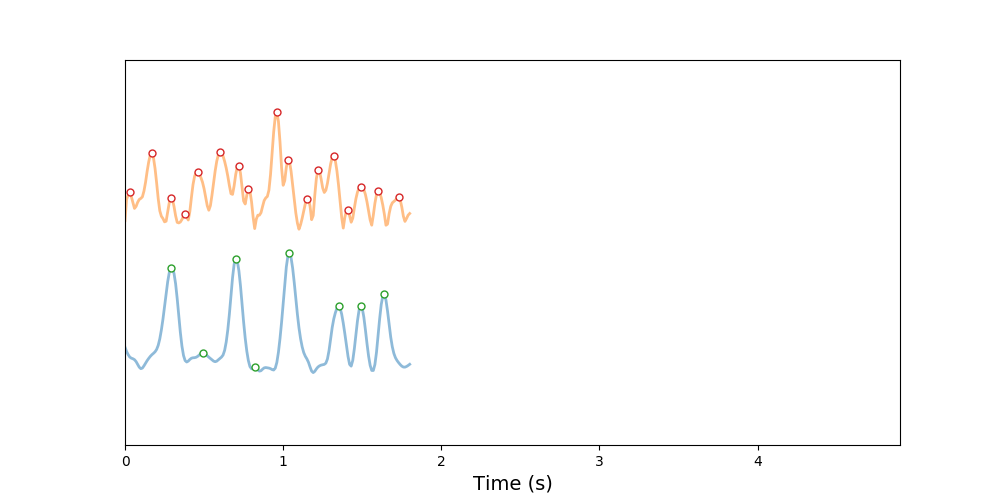

In [6]:
"""
Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(10,5))
ax = plt.axes(xlim=(0, out_dict['tvec_ds'][-1]),ylim=(-0.5, 0.7))
line_theta, = ax.plot([], [], lw=2, alpha=0.5)
line_gamma, = ax.plot([], [], lw=2, alpha=0.5)
peaks_theta, = ax.plot([], [],"o", lw=2, markersize=5, markerfacecolor='w')
peaks_gamma, = ax.plot([], [],"o", lw=2, markersize=5, markerfacecolor='w')
ax.set_xlabel('Time (s)',fontsize=14)
ax.set_yticks([])
ax.set_ylim([-0.5,1.3])

# initialization function: plot the background of each frame
def init():
    line_theta.set_data([], [])
    line_gamma.set_data([], [])
    peaks_theta.set_data([], [])
    peaks_gamma.set_data([], [])
    return line_theta,line_gamma,peaks_theta,peaks_gamma

# animation function.  This is called sequentially
def animate(i):
    gxo = 0.5 # gamma x-axis offset
    gs = 3 # gamma scale
    
    x = out_dict['tvec_ds'][:int(i)]
    line_theta.set_data(x, out_dict['theta_filt_ds'][:int(i)])
    line_gamma.set_data(x, gxo + gs*out_dict['gamma_env_ds'][:int(i)])
    peaks_theta.set_data(x, out_dict['masked_theta_filt'][:int(i)])
    peaks_gamma.set_data(x, gxo + gs*out_dict['masked_gamma_env'][:int(i)])
    
    return line_theta,line_gamma,peaks_theta,peaks_gamma

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(out_dict['tvec_ds']), interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.
# https://superuser.com/questions/624561/install-ffmpeg-on-os-x
# The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save(f'RL96_OB_sess{sess}_gamma_theta_peaks_40fps.mp4', fps=40, extra_args=['-vcodec', 'libx264'])



In [ ]:
# Supercollider sound file for this video will be located in
# /Users/brainbow/Music/SuperCollider Recordings/RL_96_OB_sess1.aiff